In [1]:
from notebooks.util.distribution_utils import *
from liquidity.features import compute_aggregate_features

from market_impact.util.utils import normalize_imbalances

from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Bin/window size for computing events
T = 1000

## Load limit orders raw sample data

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'limit_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

In [5]:
tsla_raw_df

,Unnamed: 0,event_timestamp,side,lob_action,order_executed,execution_price,execution_size,ask,ask_volume,bid,...,sign,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,184298,2017-01-03 10:30:06.086276667,ASK,INSERT,False,NaN,0,219.39,600.0,219.24,...,1,0.000,0.000,0.15,2017-01-03,-0.008536,1046891,10525,0.008043,1
1,184301,2017-01-03 10:30:07.196391542,BID,INSERT,False,NaN,0,219.39,601.0,219.24,...,-1,0.005,-0.005,0.15,2017-01-03,-0.008536,1046891,10525,0.735490,-100
2,184306,2017-01-03 10:30:11.045448316,ASK,INSERT,False,NaN,0,219.39,601.0,219.25,...,1,-0.005,-0.005,0.14,2017-01-03,-0.008536,1046891,10525,0.804315,100
3,184310,2017-01-03 10:30:11.050966641,BID,INSERT,False,NaN,0,219.38,100.0,219.25,...,-1,0.010,-0.010,0.13,2017-01-03,-0.008536,1046891,10525,0.147098,-20
4,184315,2017-01-03 10:30:13.741020687,BID,INSERT,False,NaN,0,219.38,100.0,219.27,...,-1,0.005,-0.005,0.11,2017-01-03,-0.008536,1046891,10525,0.735490,-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916012,132494,2017-12-29 14:59:50.387381942,ASK,INSERT,False,NaN,0,311.07,60.0,311.02,...,1,0.000,0.000,0.05,2017-12-29,-0.009936,831774,10502,0.197427,30
3916013,132495,2017-12-29 14:59:50.387424556,ASK,INSERT,False,NaN,0,311.07,90.0,311.02,...,1,0.005,0.005,0.05,2017-12-29,-0.009936,831774,10502,0.065809,10
3916014,132524,2017-12-29 14:59:51.681088180,BID,INSERT,False,NaN,0,311.10,3400.0,311.00,...,-1,0.000,-0.000,0.10,2017-12-29,-0.009936,831774,10502,0.331081,-50
3916015,132535,2017-12-29 14:59:57.755582069,ASK,INSERT,False,NaN,0,311.10,3400.0,311.00,...,1,0.000,0.000,0.10,2017-12-29,-0.009936,831774,10502,0.658091,100


## 1. Orderflow

### 1.1. Size/ Volume

In [6]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_size'],
               'MSFT': amzn_raw_df['norm_size'],
               'AMZN': nflx_raw_df['norm_size'],
               'NFLX': msft_raw_df['norm_size'],
               'EBAY': ebay_raw_df['norm_size'],
               'AAPL': appl_raw_df['norm_size'],
               }

# Order signed volume
signed_volume = {'TSLA': tsla_raw_df['signed_volume'],
               'MSFT': amzn_raw_df['signed_volume'],
               'AMZN': nflx_raw_df['signed_volume'],
               'NFLX': msft_raw_df['signed_volume'],
               'EBAY': ebay_raw_df['signed_volume'],
               'AAPL': appl_raw_df['signed_volume'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [7]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -66.67
p-value: 0.00,
N: 499921, 
critical values: {'1%': -3.430363080733911, '5%': -2.861545781530421, '10%': -2.5667730772974506}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -51.93
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -53.44
p-value: 0.00,
N: 499900, 
critical values: {'1%': -3.4303630812834145, '5%': -2.8615457817732946, '10%': -2.5667730774267237}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -50.28
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



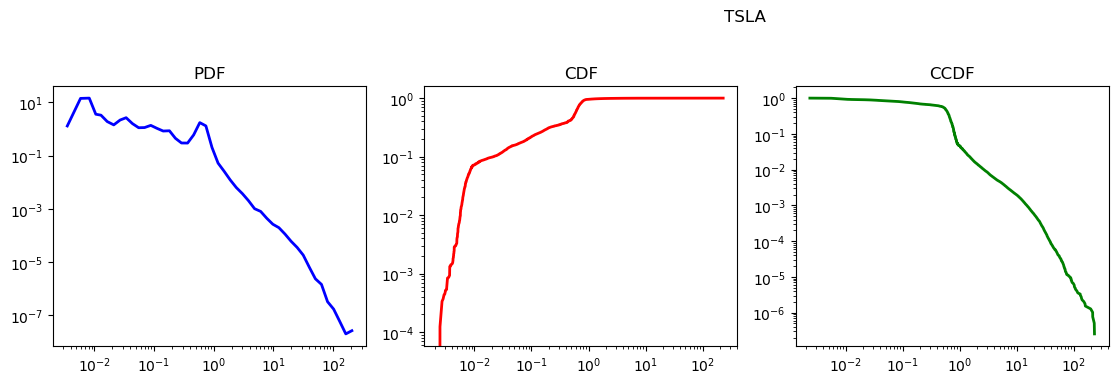

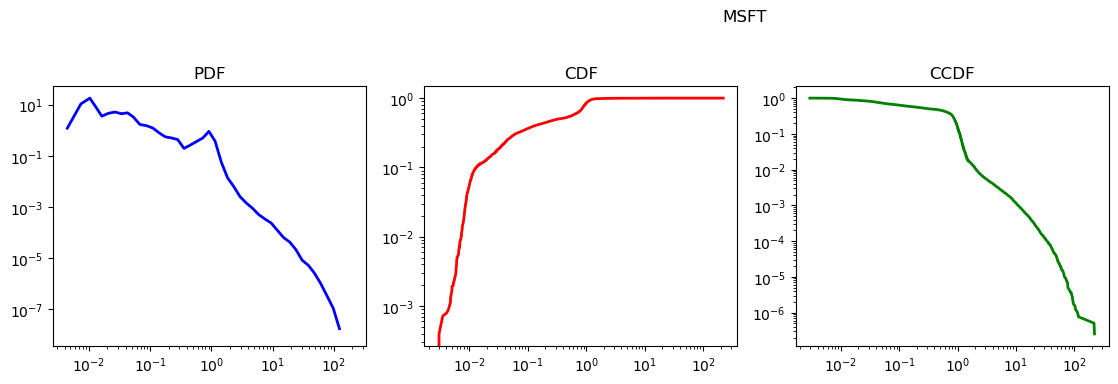

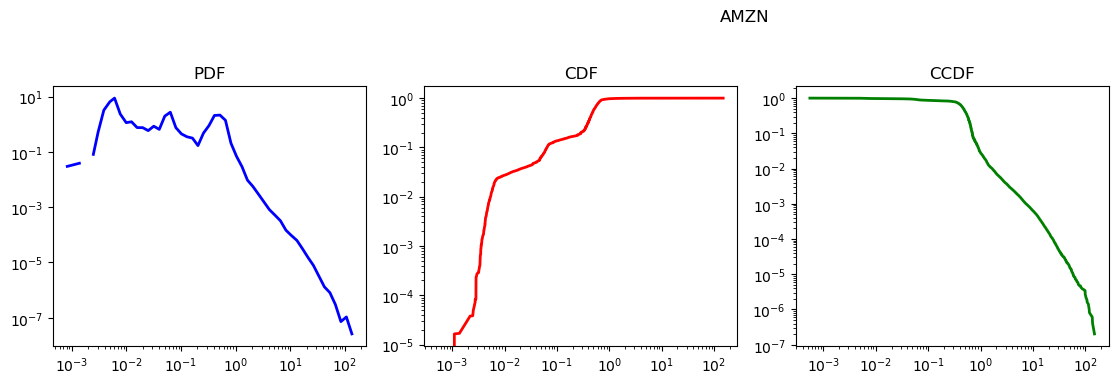

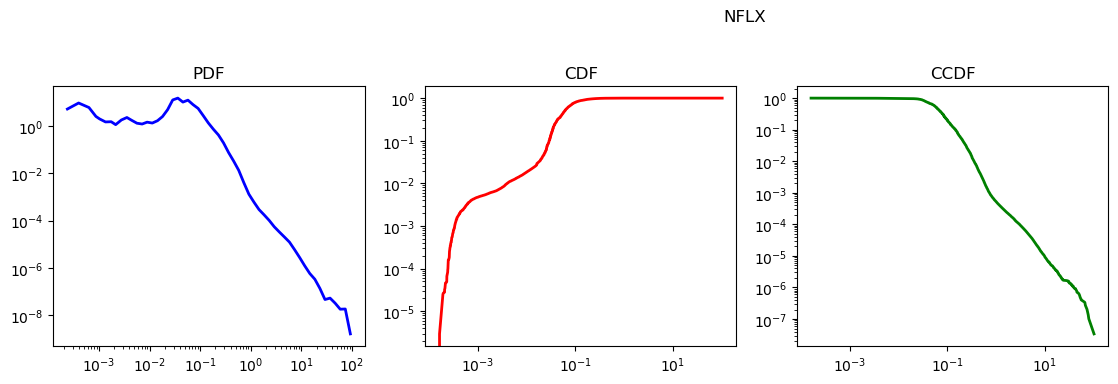

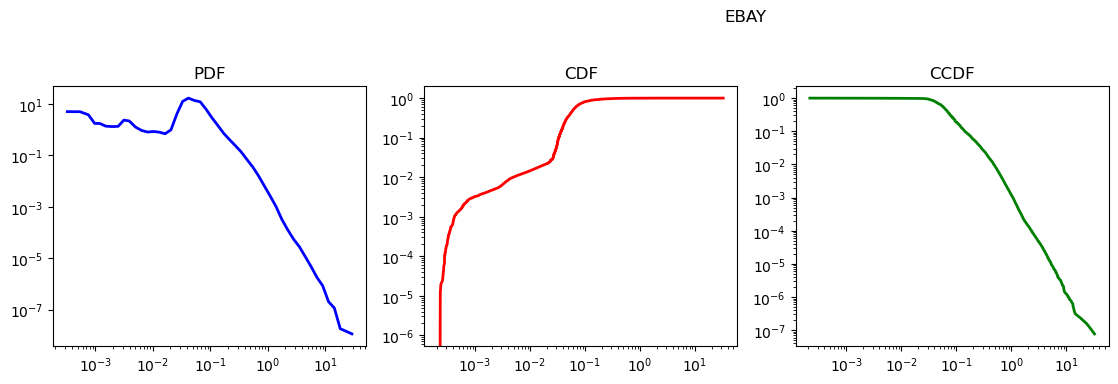

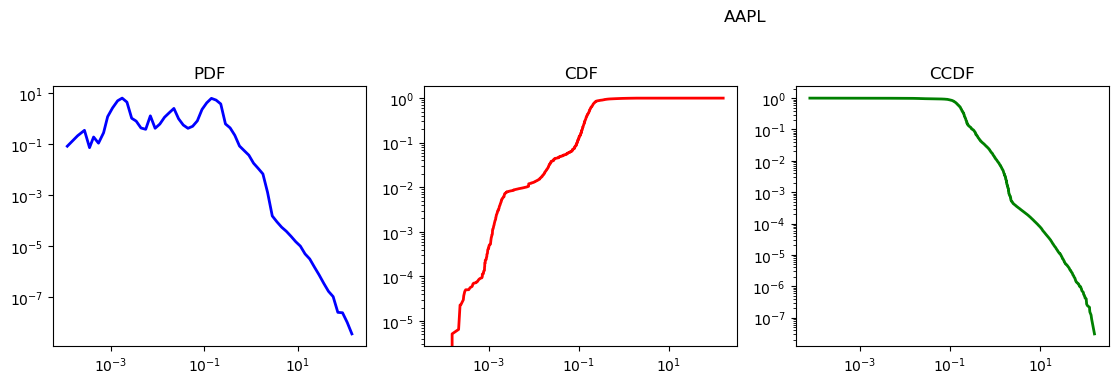

In [8]:
# Plot distribution of size_volume for each stock
for stock_name, data in size_volume.items():
    plot_distributions(stock_name, data)

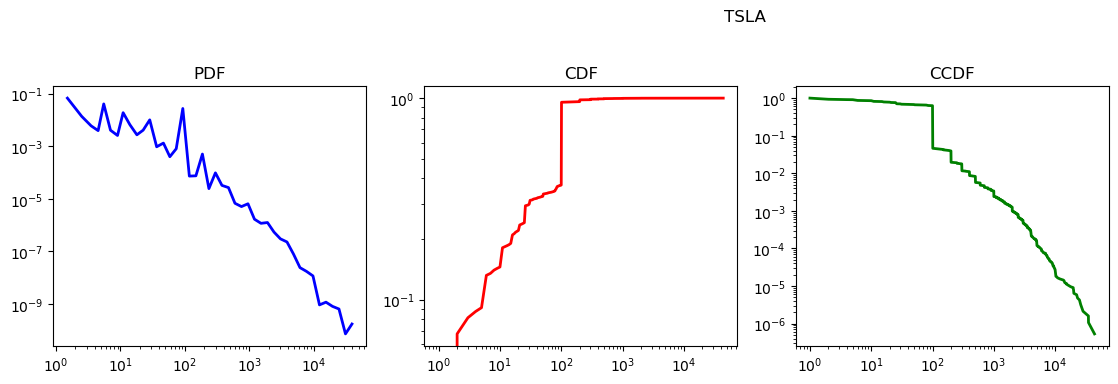

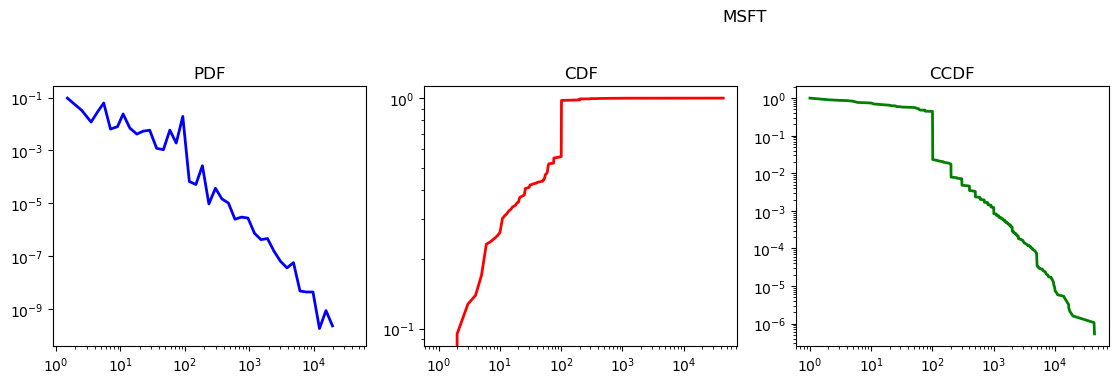

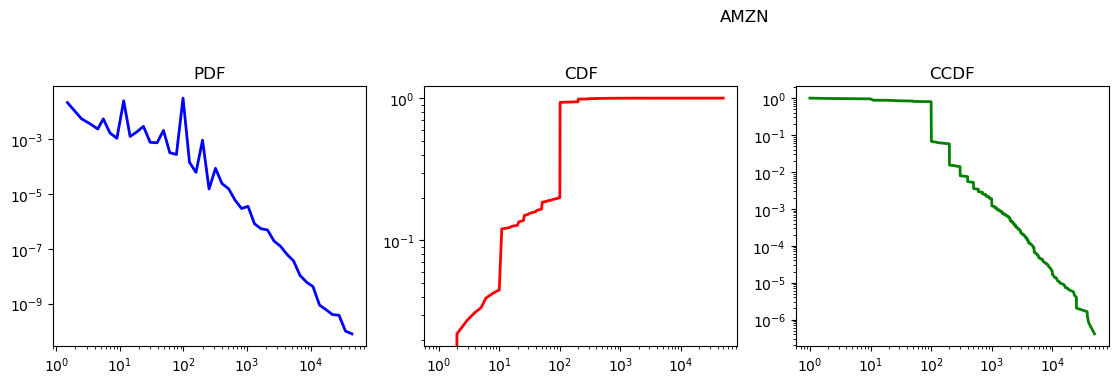

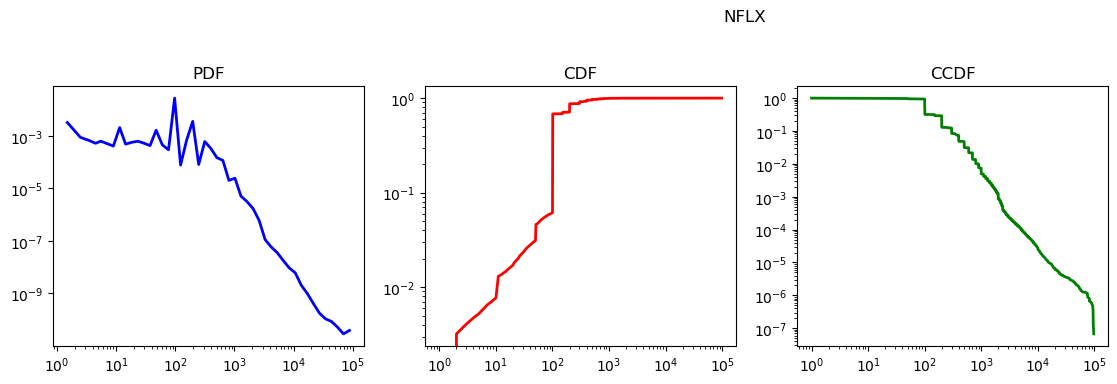

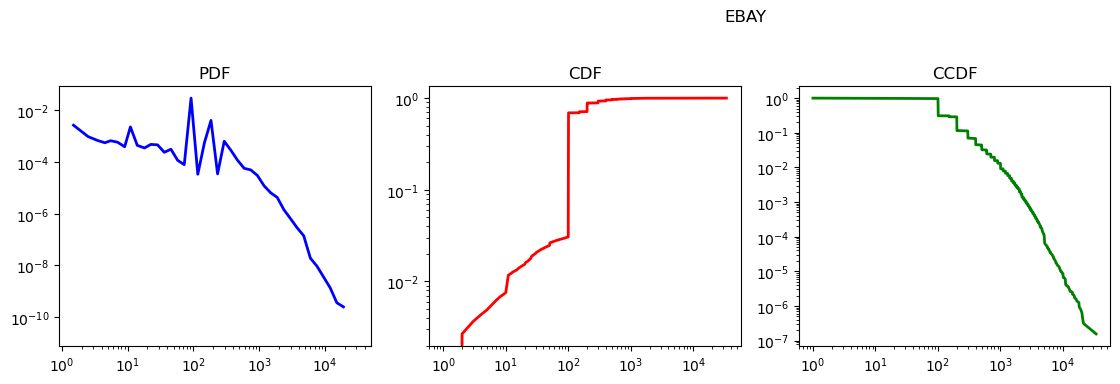

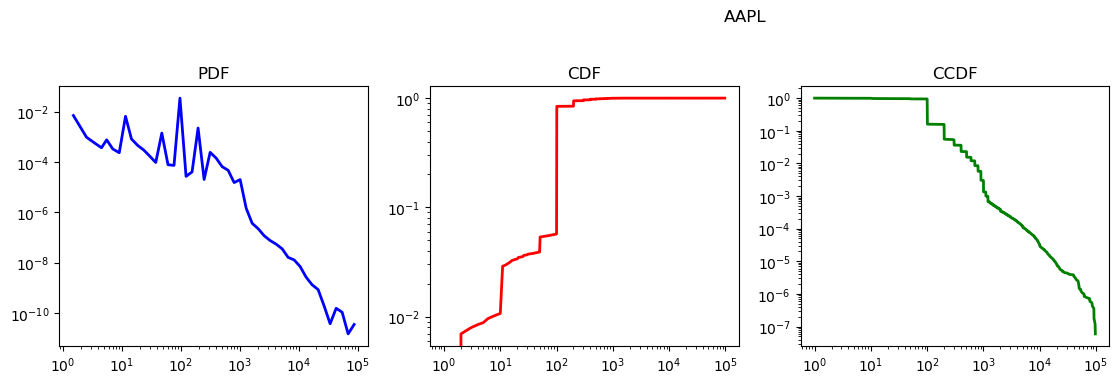

In [9]:
# Plot distribution of size_volume for each stock
for stock_name, data in signed_volume.items():
    plot_distributions(stock_name, data)

### 1.2. Fit power law distribution

In [ ]:
# 1. Fit Powerlaw and retrieve fitted object/ results
size_volume_data = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'distributions', 'lo_signed_volume_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(size_volume_data):
    volume_fit_objects = fit_powerlaw(data_dict=signed_volume, filename=size_volume_data)
else:
    volume_fit_objects = load_fit_objects(size_volume_data)

volume_fit_objects

Calculating best minimal value for power law fit


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


Calculating best minimal value for power law fit


In [ ]:
# Plot fitted objects
plot_fit_objects(volume_fit_objects)

#### 1.2.1 Retrieve Power law fitting results

In [ ]:
# Get power_law fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'power_law')
print(volume_fit_results)

In [ ]:
# Average Alpha exponents across stocks
min_alpha = volume_fit_results['alpha'].min()
max_alpha = volume_fit_results['alpha'].max()
avg_alpha = volume_fit_results['alpha'].mean()
std_dev_alpha = volume_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

In [ ]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'truncated_power_law')
print(volume_fit_results)

In [ ]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'exponential')
print(volume_fit_results)

#### 1.2.2. Compare alternative distributions

In [ ]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_comparison = distribution_compare(volume_fit_objects, 'exponential')
display(volume_comparison)

## 2. Signed Ordeflow Imbalance

In [ ]:
# Aggregate orderflow
tsla_aggregate_orderflow = compute_aggregate_features(tsla_raw_df, [T])
msft_aggregate_orderflow = compute_aggregate_features(msft_raw_df, [T])
amzn_aggregate_orderflow = compute_aggregate_features(amzn_raw_df, [T])
nflx_aggregate_orderflow = compute_aggregate_features(nflx_raw_df, [T])
ebay_aggregate_orderflow = compute_aggregate_features(ebay_raw_df, [T])
appl_aggregate_orderflow = compute_aggregate_features(appl_raw_df, [T])

# Normalize imblances
tsla_aggregate_orderflow = normalize_imbalances(tsla_aggregate_orderflow)
msft_aggregate_orderflow = normalize_imbalances(msft_aggregate_orderflow)
amzn_aggregate_orderflow = normalize_imbalances(amzn_aggregate_orderflow)
nflx_aggregate_orderflow = normalize_imbalances(nflx_aggregate_orderflow)
ebay_aggregate_orderflow = normalize_imbalances(ebay_aggregate_orderflow)
appl_aggregate_orderflow = normalize_imbalances(appl_aggregate_orderflow)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'AAPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}

# Signed Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['volume_imbalance'],
 'MSFT': msft_aggregate_orderflow['volume_imbalance'],
 'AMZN': amzn_aggregate_orderflow['volume_imbalance'],
 'NFLX': nflx_aggregate_orderflow['volume_imbalance'],
 'EBAY': ebay_aggregate_orderflow['volume_imbalance'],
 'AAPL': appl_aggregate_orderflow['volume_imbalance']
}
#volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

### Stationarity Tests

In [ ]:
# sign_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)
print('\n')


In [ ]:
# volume_imbalance ADF test
print('Signed-volume Imbalance')
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 2.1. Order Sign Imbalance

In [ ]:
# Plot distribution of sign_imbalance for each stock
for stock_name, data in sign_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.1.1. Fit power law distribution

In [ ]:
# 1. Fit Powerlaw and retrieve fitted object/ results
sign_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'distributions', 'lo_sign_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(sign_imbalance_data):
    sign_imbalance_fit_objects = fit_powerlaw(data_dict=sign_imbalance, filename=sign_imbalance_data)
else:
    sign_imbalance_fit_objects = load_fit_objects(sign_imbalance_data)

sign_imbalance_fit_objects

In [ ]:
# Plot fitted objects
plot_fit_objects(sign_imbalance_fit_objects)

#### 2.1.2. Retrieve Power law fitting results

In [ ]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'power_law')
print(sign_imbalance_fit_results)

In [ ]:
# Average Alpha exponents across stocks
min_alpha = sign_imbalance_fit_results['alpha'].min()
max_alpha = sign_imbalance_fit_results['alpha'].max()
avg_alpha = sign_imbalance_fit_results['alpha'].mean()
std_dev_alpha = sign_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

In [ ]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'truncated_power_law')
print(sign_imbalance_fit_results)

In [ ]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_exp_results = get_fitting_params(sign_imbalance_fit_objects, 'exponential')
print(sign_imbalance_exp_results)

#### 2.1.3. Compare alternative distributions

In [ ]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
sign_imbalance_comparison = distribution_compare(sign_imbalance_fit_objects, 'exponential')
display(sign_imbalance_comparison)

### 2.2. Volume Imbalance

In [ ]:
# Plot distribution of volume_imbalance for each stock
for stock_name, data in volume_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.2.1. Fit power law distribution

In [ ]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volume_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'distributions', 'lo_volume_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volume_imbalance_data):
    volume_imbalance_data_fit_objects = fit_powerlaw(data_dict=volume_imbalance, filename=volume_imbalance_data)
else:
    volume_imbalance_data_fit_objects = load_fit_objects(volume_imbalance_data)

volume_imbalance_data_fit_objects

In [ ]:
# Plot fitted objects
plot_fit_objects(volume_imbalance_data_fit_objects)

#### 2.2.2. Retrieve Power law fitting results

In [ ]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'power_law')
print(volume_imbalance_fit_results)

In [ ]:
# Average Alpha exponents across stocks
min_alpha = volume_imbalance_fit_results['alpha'].min()
max_alpha = volume_imbalance_fit_results['alpha'].max()
avg_alpha = volume_imbalance_fit_results['alpha'].mean()
std_dev_alpha = volume_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

In [ ]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'truncated_power_law')
print(volume_imbalance_fit_results)

In [ ]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'exponential')
print(volume_imbalance_fit_results)

#### 2.2.3. Compare alternative distributions

In [ ]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_imbalance_comparison = distribution_compare(volume_imbalance_data_fit_objects, 'exponential')
display(volume_imbalance_comparison)